<a href="https://colab.research.google.com/github/raniaAprilia/Capstone-Project-SDI-2025/blob/main/Capstone_Project_SDI_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/trip-advisor-hotel-reviews

In [ ]:
!unzip /content/trip-advisor-hotel-reviews.zip

In [1]:
import os
import pandas as pd

df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


## Labelling

In [3]:
def label_sentiment(rating):
  if rating <= 2:
    return 'Negative'
  elif rating >= 4:
    return 'Positive'
  else:
    return 'Neutral'

df['Sentiment'] = df['Rating'].apply(label_sentiment)
df.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

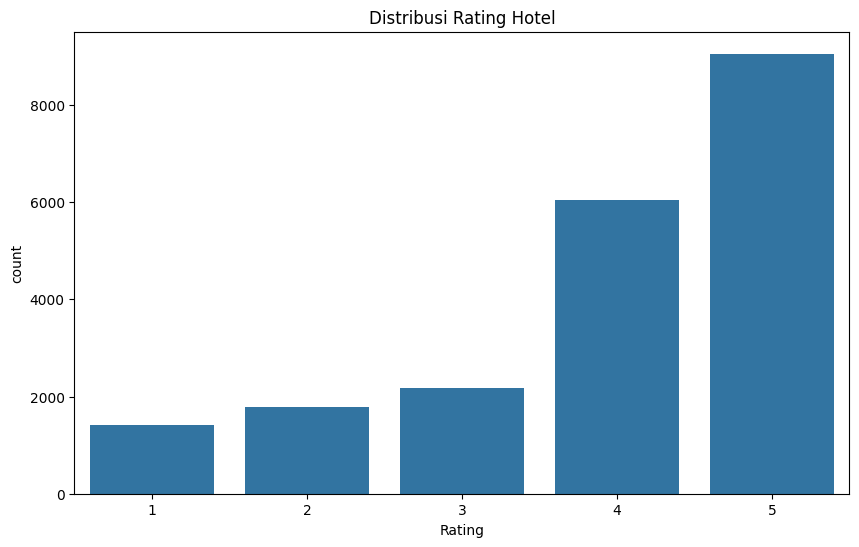

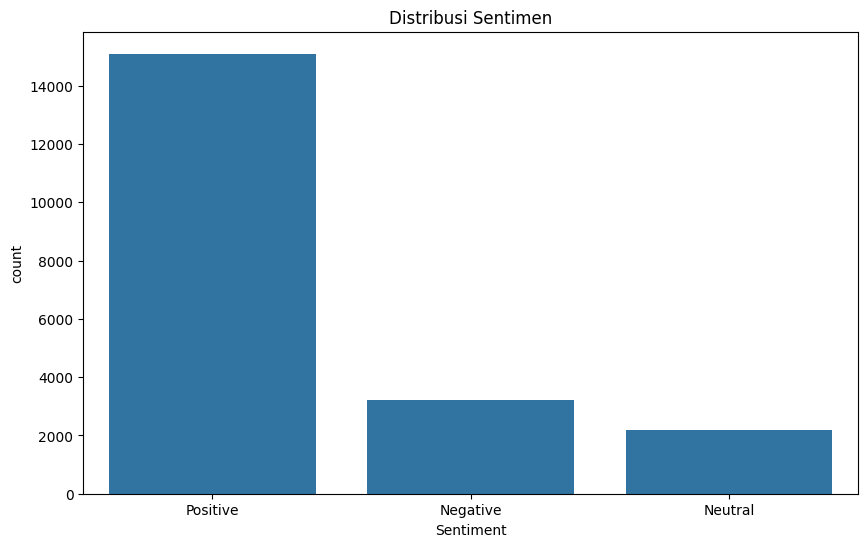

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df)
plt.title('Distribusi Rating Hotel')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.show()

## Preprocessing

In [6]:
df['Cleaned_Review'] = df['Review'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
sample_reviews = df[['Cleaned_Review', 'Sentiment']].sample(5, random_state=42)
customer_reviews = sample_reviews['Cleaned_Review'].tolist()
formatted_reviews = [f"- {review}" for review in customer_reviews]
formatted_review_str = "\n".join(formatted_reviews)

In [7]:
df.head()

,Review,Rating,Sentiment,Cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,Positive,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,Negative,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral,nice rooms not 4 experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,Positive,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,Positive,great stay great stay went seahawk game awesom...


## Data Distribution


In [83]:
prompt = f"""
Anda adalah seorang analis sentimen profesional untuk review hotel. Analisis review berikut dengan struktur berikut:

=== REVIEW ===
{formatted_review_str}

=== INSTRUKSI ANALISIS ===
- Berikan 3 aspek utama untuk setiap review review
- Berikan 2 sentimen utama untuk setiap review
- Berikan 2 rekomendasi untuk pengelola hotel untuk memperbaiki review negatif


"""

print(prompt)


Anda adalah seorang analis sentimen profesional untuk review hotel. Analisis review berikut dengan struktur berikut:

=== REVIEW ===
- not recommend hotel did reviewers actually stay hotel did good thing hotel location really close leidseplein shared facilities filthy got did not look toilet floor cleaned month facilities not cleaned 3 days got disgusting staff rude complained left night early refused refund night not recommend hotel  
- barcelona rocks stayed hotel jazz girlfriend 3 nights end augustthe hotel excellent location carrer pelai close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds caught airport bus barcelona costs 7 euros person return trip hotel located 2 mins walk maximum placa universitat stop 2nd route hotel modern clean air conditioning room superb balcony looking street outside room good size bathroom fine scrimp bit toiletries bring shower gels unless consider washing unnecessary luxury travelsthe downside hotel possibly strengths depen

In [76]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
api_token = userdata.get('api_token')
os.environ['REPLICATE_API_TOKEN'] = api_token

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "repetition_penalty": 1.0,
  "temperature": 0,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}

model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
    model=model,
    replicate_api_token = api_token,
    input=parameters
    )

In [84]:
# Kirim prompt ke LLM
response = output(prompt)
# Tambahkan ini untuk bersihkan Markdown (**...**)
import re

output_clean = re.sub(r"\*\*(.*?)\*\*", r"\1", response)
print(output_clean)

## Analisis Sentimen dan Aspek Utama untuk Setiap Review Hotel

Review 1:
- Aspek Utama: Kualitas Kamar, Kualitas Layanan, Kualitas Lingkungan
- Sentimen Utama: Negatif (Kualitas Kamar & Layanan Buruk, Kualitas Lingkungan Buruk)
- Rekomendasi untuk Pengelola Hotel:
  1. Memperbaiki Kualitas Kamar: Perbaiki kebersihan kamar, termasuk pembersihan toilet dan tetapan lantai.
  2. Memperbaiki Kualitas Layanan: Pelatihan staf untuk meningkatkan kualitas layanan dan sopan santun terhadap tamu.

Review 2:
- Aspek Utama: Lokasi, Kualitas Kamar, Kualitas Layanan
- Sentimen Utama: Positif (Lokasi Ekscetra, Kualitas Kamar Baik, Layanan Baik)
- Rekomendasi untuk Pengelola Hotel:
  1. Memperbaiki Minibar: Perbaiki harga minibar agar lebih kompetitif dan menarik.
  2. Memperbaiki Infrastruktur Ruang Publik: Perbaiki aksesibilitas dan kenyamanan ruang publik, seperti lobby dan pusat daya.

Review 3:
- Aspek Utama: Kualitas Kamar, Kualitas Layanan, Kualitas Lingkungan
- Sentimen Utama: Positif (Kualita

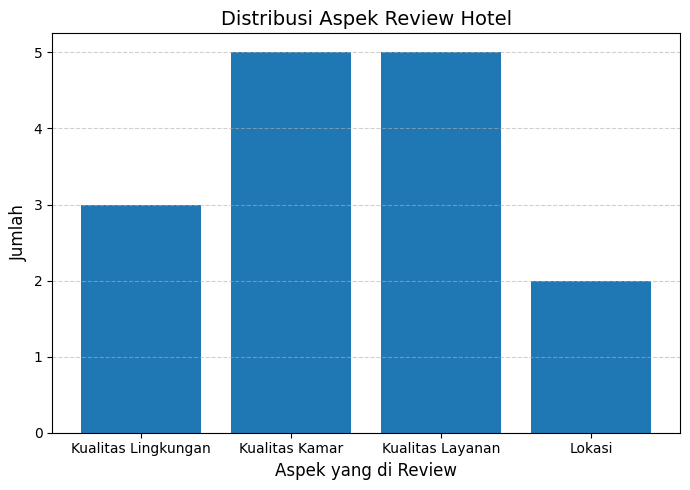

In [87]:
# Data klasifikasi hasil output IBM Granite
aspect = ['Kualitas Lingkungan', 'Kualitas Kamar', 'Kualitas Layanan', 'Lokasi']
counts = [3, 5, 5, 2]  # Sesuaikan ini dengan jumlah aspirasi dari output



# Buat bar chart
plt.figure(figsize=(7, 5))
plt.bar(aspect, counts)

# Judul dan label
plt.title("Distribusi Aspek Review Hotel", fontsize=14)
plt.xlabel("Aspek yang di Review", fontsize=12)
plt.ylabel("Jumlah", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tampilkan
plt.tight_layout()
plt.show()

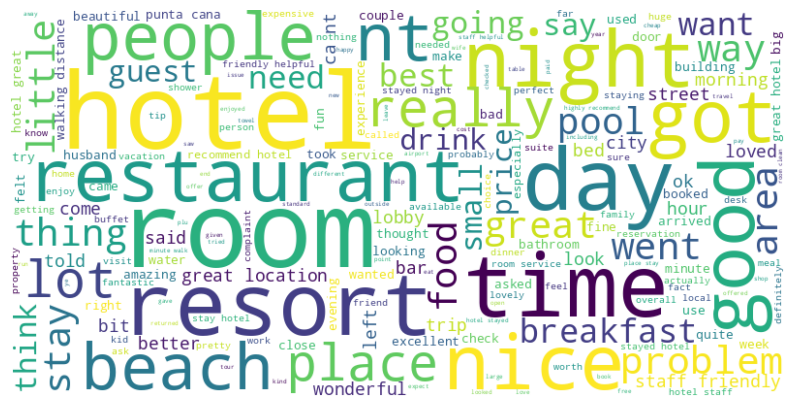

In [91]:
from wordcloud import WordCloud

# Gabungkan semua review yang dibersihkan menjadi satu string
all_reviews = ' '.join(df['Cleaned_Review'])

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, random_state=21, background_color='white',max_font_size=110).generate(all_reviews)

# Plot wordcloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()